# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

See full course materials on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/

In [1]:
# Are we using a GPU?
!nvidia-smi

Thu Jan 19 09:44:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |      0MiB / 15109MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Necessary Libraries

In [2]:
# Frameworks to build models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Frameworks to support model
import os
import zipfile
import pathlib
import datetime
import random

## Download the Dataset

In [5]:
# Get data (10% of the Food 101 classes)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2023-01-19 09:44:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.251.163.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   181MB/s    in 0.9s    

2023-01-19 09:44:13 (181 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# view our dataset directory
!ls 10_food_classes_10_percent

test  train


In [7]:
# walk through the data directory & list the number of files
for dir_path, dir_fol, dir_files in os.walk("10_food_classes_10_percent"):
  print(f" There are {len(dir_fol)} diectories and {len(dir_files)} images in {dir_path}")

 There are 2 diectories and 0 images in 10_food_classes_10_percent
 There are 10 diectories and 0 images in 10_food_classes_10_percent/test
 There are 0 diectories and 250 images in 10_food_classes_10_percent/test/hamburger
 There are 0 diectories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
 There are 0 diectories and 250 images in 10_food_classes_10_percent/test/fried_rice
 There are 0 diectories and 250 images in 10_food_classes_10_percent/test/sushi
 There are 0 diectories and 250 images in 10_food_classes_10_percent/test/ramen
 There are 0 diectories and 250 images in 10_food_classes_10_percent/test/ice_cream
 There are 0 diectories and 250 images in 10_food_classes_10_percent/test/steak
 There are 0 diectories and 250 images in 10_food_classes_10_percent/test/chicken_wings
 There are 0 diectories and 250 images in 10_food_classes_10_percent/test/pizza
 There are 0 diectories and 250 images in 10_food_classes_10_percent/test/chicken_curry
 There are 10 diectori

## Creating data loaders

In [8]:
# Setting up the train & test directories
train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/" 

# Normalizing train & test datasets
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# hyper-parameters
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

# loading data from the directories & turn into batches
print("Training images:")
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size = IMAGE_SHAPE,
                                               class_mode="categorical",
                                               batch_size=BATCH_SIZE)

print("Test images:")
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [9]:
# create a TensorBoard callback (functionized because we need one for each model)
def tensorboard_callback(dir_name, experiment_name):
  logs_directory = dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%d%m%Y-%H%M%S")
  TensorBoard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_directory)
  print(f"Saving TensorBoard logfiles to: {logs_directory}")
  return TensorBoard_callback

> 🔑 **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majroity of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [10]:
# Let's Compare the following 2 models
EfficientNet_B0 = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

ResNet_50_V2 = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [11]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [12]:
# Let's make a create_function to create a model from URL
def create_model(model_url, num_classes=10):
  """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
      model_url (str): A TensorFlow Hub feature extraction URL.
      num_classes (int): Number of output neurons in the output layer,
        should be equal to number of target classes, default 10.
    
    Returns:
      An uncompiled Keras Sequential model with model_url as feature extractor
      layer and Dense output layer with num_classes output neurons.
  """
  # Download the pre-trained model save it as Keras Layer
  feature_extractor_layer = hub.KerasLayer(handle=model_url,
                                           trainable = False,
                                           name="feature_extractor_layer",
                                           input_shape = IMAGE_SHAPE+(3,))
  
  #set seed
  tf.random.set_seed(42)
  
  # Build the model
  model = tf.keras.Sequential(
      [
          feature_extractor_layer,
          tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
      ]
  )

  # Compile the model
  model.compile(loss = "categorical_crossentropy",
                             optimizer = "Adam",
                             metrics=["accuracy"])
  return model

## Creating & Testing ResNet_50_v2 model

In [13]:
# Creating the ReBNet_50_V2 Model
ResNet_50_V2_Model = create_model(model_url=ResNet_50_V2, num_classes=train_data.num_classes)

In [14]:
# Fit the model
ResNet_history = ResNet_50_V2_Model.fit(train_data,
                       epochs=5,
                       steps_per_epoch = len(train_data),
                       validation_data = test_data,
                       validation_steps = len(test_data),
                       callbacks = [tensorboard_callback(dir_name="tensorflow_hub", experiment_name="ResNet_50_V2_Experiment")]
                       )

Saving TensorBoard logfiles to: tensorflow_hub/ResNet_50_V2_Experiment/19012023-094422
Epoch 1/5
24/24 [==============================] - 28s 747ms/step - loss: 1.8444 - accuracy: 0.3760 - val_loss: 1.1195 - val_accuracy: 0.6664
Epoch 2/5
24/24 [==============================] - 17s 723ms/step - loss: 0.8679 - accuracy: 0.7387 - val_loss: 0.8208 - val_accuracy: 0.7420
Epoch 3/5
24/24 [==============================] - 16s 692ms/step - loss: 0.5952 - accuracy: 0.8307 - val_loss: 0.7313 - val_accuracy: 0.7656
Epoch 4/5
24/24 [==============================] - 16s 681ms/step - loss: 0.4674 - accuracy: 0.8720 - val_loss: 0.6947 - val_accuracy: 0.7744
Epoch 5/5
24/24 [==============================] - 17s 729ms/step - loss: 0.3661 - accuracy: 0.9133 - val_loss: 0.6580 - val_accuracy: 0.7876


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [15]:
# Plot the validation and training curves separately
def plot_loss_curve(meta):

  fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))

  loss = meta.history["loss"]
  accuracy = meta.history["accuracy"]

  val_loss = meta.history["val_loss"]
  val_accuracy = meta.history["val_accuracy"]

  epochs = range(len(meta.history["loss"]))

  sns.lineplot(data=meta.history, y=loss, x=epochs, label="loss", ax=ax1)
  sns.lineplot(data=meta.history, y=val_loss, x=epochs, label="val_loss", ax=ax1).set(title="Loss Curve", xlabel="epochs")
  ax1.grid(False)
  ax1.legend(loc="upper right");
 

  sns.lineplot(x=epochs, y=accuracy, label="accuracy", ax=ax2)
  sns.lineplot(x=epochs, y=val_accuracy, label="val_accuracy", ax=ax2).set(title="Accuracy Curve", xlabel="epochs")
  ax2.grid(False)
  ax2.legend(loc="lower right");


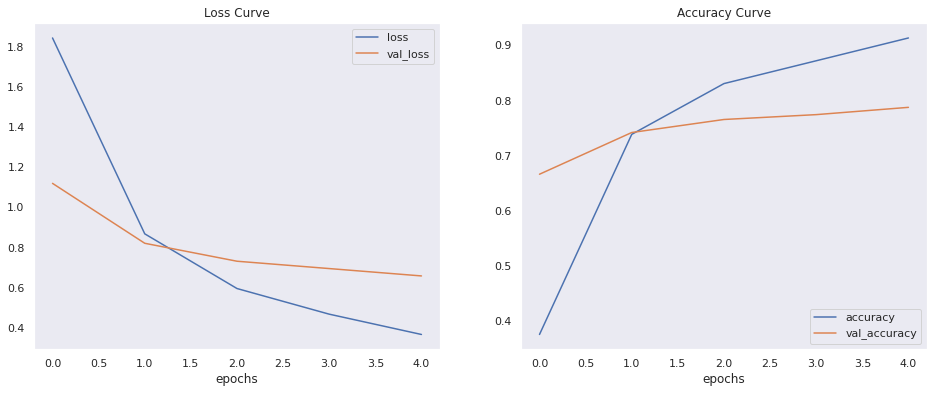

In [16]:
plot_loss_curve(ResNet_history)

## Creating & Testing EfficientNet_b0 model

In [17]:
# Creating EfficientNet B0 feature extractor model
EfficientNet_B0_model = create_model(model_url=EfficientNet_B0,
                                     num_classes = train_data.num_classes)


In [18]:
# Fit EfficientNet B0 model 
EfficientNet_history = EfficientNet_B0_model.fit(train_data,
                          epochs = 5,
                          steps_per_epoch = len(train_data),
                          validation_data = test_data,
                          validation_steps = len(test_data),
                          callbacks = [tensorboard_callback(dir_name="tensorflow_hub", experiment_name="EfficientNet_B0_Experiment")] 
                          )

Saving TensorBoard logfiles to: tensorflow_hub/EfficientNet_B0_Experiment/19012023-094612
Epoch 1/5
24/24 [==============================] - 25s 700ms/step - loss: 1.8386 - accuracy: 0.4267 - val_loss: 1.2714 - val_accuracy: 0.7320
Epoch 2/5
24/24 [==============================] - 15s 639ms/step - loss: 1.0528 - accuracy: 0.7587 - val_loss: 0.8569 - val_accuracy: 0.8224
Epoch 3/5
24/24 [==============================] - 15s 649ms/step - loss: 0.7504 - accuracy: 0.8440 - val_loss: 0.6892 - val_accuracy: 0.8460
Epoch 4/5
24/24 [==============================] - 15s 635ms/step - loss: 0.6032 - accuracy: 0.8680 - val_loss: 0.6012 - val_accuracy: 0.8592
Epoch 5/5
24/24 [==============================] - 15s 632ms/step - loss: 0.5091 - accuracy: 0.9040 - val_loss: 0.5512 - val_accuracy: 0.8648


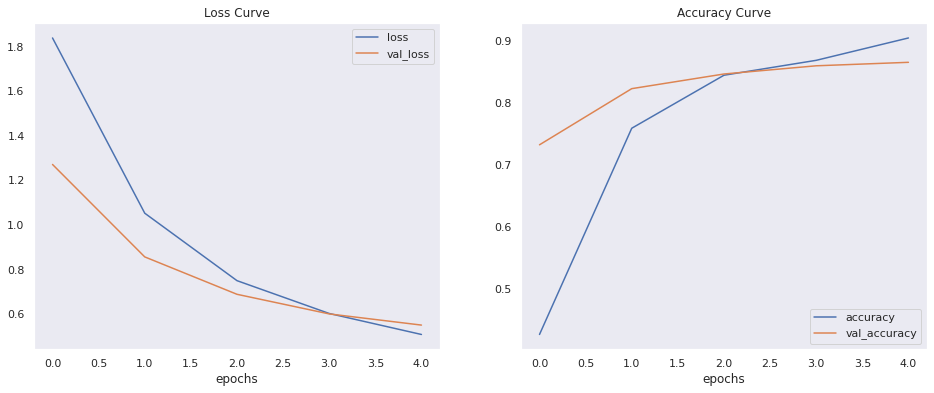

In [19]:
plot_loss_curve(EfficientNet_history)

In [20]:
ResNet_50_V2_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [21]:
EfficientNet_B0_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [22]:
# ResNet 50 V2 model layers
ResNet_50_V2_Model.layers

In [23]:
# Architecture of the ResNet 50 V2
ResNet_layers = ResNet_50_V2_Model.layers
print("Architecture of the ResNet 50 V2")
print(ResNet_layers, end='\n')

print(f"Total Number of layers:\n {len(ResNet_layers[0].weights)}")

Architecture of the ResNet 50 V2
[<tensorflow_hub.keras_layer.KerasLayer object at 0x7f00fa4a4220>, <keras.layers.core.dense.Dense object at 0x7f00965cefa0>]
Total Number of layers:
 270


In [24]:
# ResNet 50 V2 models weights & biases
weights = ResNet_layers[0].get_weights()[0]
bias = ResNet_layers[0].get_weights()[1]

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)


## Comparing our models results using TensorBoard

> 🔑 **Note:** When you upload things to [TensorBoard.dev](https://tensorboard.dev/), you experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [25]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "ResNet50_V2 vs. EfficientNet_B0" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO


Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/dQBrpdwIRgS2qI0Andv8Yg/

In [26]:
# Checkout what tensorflow experiments you have
!tensorboard dev list


***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO


In [27]:
# Delete an experiment
#!tensorboard dev delete --experiment_id uQe6RTPbSEGivZTp2DKmcg

In [28]:
# Confirm deletion by rechecking what you have
!tensorboard dev list


***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO
